<a href="https://colab.research.google.com/github/carolynw898/STAT946Proj/blob/main/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
import torch

n_embd = 512
timesteps = 1000
batch_size = 256
learning_rate = 1e-4
num_epochs = 10
blockSize = 32
testBlockSize = 400
numVars = 2
numYs = 1
numPoints = 250
target = 'Skeleton'
const_range = [-2.1, 2.1]
trainRange = [-3.0, 3.0]
decimals = 8
addVars = False
maxNumFiles = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [21]:
dataDir = "/content/drive/MyDrive/Colab/STAT946_proj/data"
dataFolder = "2_var_dataset"

In [22]:
from torch.utils.data import DataLoader
import numpy as np
import glob
from utils import processDataFiles, CharDataset, tokenize_equation
import random
import json

path = '{}/{}/Train/*.json'.format(dataDir, dataFolder)
files = glob.glob(path)[:maxNumFiles]
text = processDataFiles(files)
text = text.split('\n') # convert the raw text to a set of examples
# skeletons = []
skeletons = [json.loads(item)['Skeleton'] for item in text if item.strip()]
all_tokens = set()
for eq in skeletons:
    all_tokens.update(tokenize_equation(eq))
integers = {'0', '1', '2', '3', '4', '5', '6', '7', '8', '9'}
all_tokens.update(integers)  # add all integers to the token set
tokens = sorted(list(all_tokens) + ['_', 'T', '<', '>', ':'])  # special tokens
trainText = text[:-1] if len(text[-1]) == 0 else text
random.shuffle(trainText) # shuffle the dataset, it's important specailly for the combined number of variables experiment
train_dataset = CharDataset(trainText, blockSize, tokens=tokens, numVars=numVars,
                        numYs=numYs, numPoints=numPoints, target=target, addVars=addVars,
                        const_range=const_range, xRange=trainRange, decimals=decimals)

idx = np.random.randint(train_dataset.__len__())
inputs, outputs, points, variables = train_dataset.__getitem__(idx)
inputs = ''.join([train_dataset.itos[int(i)] for i in inputs])
outputs = ''.join([train_dataset.itos[int(i)] for i in outputs])
print('id:{}\noutputs:{}\nvariables:{}'.format(idx,outputs,variables))

data has 499035 examples, 30 unique.
id:481409
outputs:C*x1+C>__________________________
variables:1


In [25]:
path = '{}/{}/Test/*.json'.format(dataDir,dataFolder)
files = glob.glob(path)
textTest = processDataFiles([files[0]])
textTest = textTest.split('\n') # convert the raw text to a set of examples
test_dataset = CharDataset(textTest, blockSize, tokens=tokens, numVars=numVars,
                        numYs=numYs, numPoints=numPoints, target=target, addVars=addVars,
                        const_range=const_range, xRange=trainRange, decimals=decimals)

# print a random sample
idx = np.random.randint(test_dataset.__len__())
inputs, outputs, points, variables = test_dataset.__getitem__(idx)
print(points.min(), points.max())
inputs = ''.join([train_dataset.itos[int(i)] for i in inputs])
outputs = ''.join([train_dataset.itos[int(i)] for i in outputs])
print('id:{}\noutputs:{}\nvariables:{}'.format(idx,outputs,variables))

test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        pin_memory=True,
        shuffle=False,
        num_workers=2
    )

data has 938 examples, 30 unique.
tensor(-3.9399) tensor(6.3575)
id:576
outputs:C*x2+C>__________________________
variables:2


In [26]:
import torch
import json
from tqdm import tqdm
from utils import sample_and_select_best

@torch.no_grad()
def test_model(model, test_loader, textTest, train_dataset, device, ddim_step=20, numTests=10):
    results = {"target": [], "target_skeleton": [], "predicted_skeleton": [], "predicted": [], "error": []}
    for batch_idx, (_, tokens, points, variables) in tqdm(
        enumerate(test_loader),
        total=len(test_loader),
        desc="Processing Test Batches",
        unit="batch"
    ):
        points = points.to(device)
        tokens = tokens.to(device)
        variables = variables.to(device)
        B = points.shape[0]
        print(f'points.shape: {points.shape}')

        for i in tqdm(
            range(B),
            total=B,
            desc=f"Batch {batch_idx+1}/{len(test_loader)} Samples",
            unit="sample",
            leave=False
        ):
            t = json.loads(textTest[batch_idx * test_loader.batch_size + i])
            eq = t["EQ"]

            eq_skeleton = ''.join([train_dataset.itos[int(k)] for k in tokens[i]])
            eq_skeleton = eq_skeleton.strip(train_dataset.paddingToken).split('>')[0].strip('<').strip(">")

            points_i = points[i:i+1]
            variables_i = variables[i:i+1]
            predicted_skeleton, predicted, err = sample_and_select_best(
                model, points_i, variables_i, train_dataset, eq, t, numTests, ddim_step
            )

            #print(f'eq: {eq}')
            #print(f'eq_skeleton: {eq_skeleton}')
            #print(f'predicted_skeleton: {predicted_skeleton}')
            #print(f'predicted: {predicted}')
            #print(f'err: {err}\n')

            results["target"].append(eq)
            results["target_skeleton"].append(eq_skeleton)
            results["predicted_skeleton"].append(predicted_skeleton)
            results["predicted"].append(predicted)
            results["error"].append(err)

    return results

In [27]:
from utils import plot_and_save_results

def run_and_plot(model, fName, test_loader, textTest, train_dataset, device, pconf=None, ddim_step=20, numTests=10):
    """Run test_model and plot results using utility functions.
    Args:
        model: SymbolicGaussianDiffusion model
        test_loader: DataLoader for test data
        textTest: list of test data
        train_dataset: dataset with itos mapping
        device: torch device
        pconf: PointNetConfig object
    """
    results = test_model(model, test_loader, textTest, train_dataset, device, ddim_step, numTests)

    modelKey = 'SymbolicDiffusion'
    resultDict = {
        fName: {
            modelKey: {
                'err': results['error'],
                'trg': results['target'],
                'prd': results['predicted']
            }
        }
    }

    titleTemplate = "{} equations of {} variables - Benchmark"
    plot_and_save_results(resultDict, fName, pconf, titleTemplate, textTest, modelKey=modelKey)

Processing Test Batches:   0%|          | 0/4 [00:00<?, ?batch/s]

points.shape: torch.Size([256, 3, 249])


Streaming output truncated to the last 5000 lines.
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a

points.shape: torch.Size([256, 3, 249])


Streaming output truncated to the last 5000 lines.
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a

points.shape: torch.Size([256, 3, 249])


Streaming output truncated to the last 5000 lines.
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a

points.shape: torch.Size([169, 3, 249])


Streaming output truncated to the last 5000 lines.
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a

Test Case 0.
Target: 0.11403466543468799*exp(0.7814917198392037*x1)+1.5036893734519117
Skeleton: 0.13988684380012972*x1+1.7527341548454305
Err: 0.058433345537925216

Test Case 1.
Target: -2.0381381693323983*x2/(-0.7830278802203807*x2+1.8479618790331518)+1.3369592996603776
Skeleton: 1.0*exp(1.0*x2)+1.0*exp(1.0*x2)+)1.0)1.0)1.0)1.01.0)+1.01.01.0
Err: 97.05385876098381

Test Case 2.
Target: 0.5174671245230469*x1+-0.7406691809860964*x2+1.263293937708446*sin(-0.22545389409558148*x1**4)+-0.14261905522141194
Skeleton: 0.3353054198562828*x1+-0.42215049761284945*x2+-0.08908436080052973
Err: 0.05021435048089927

Test Case 3.
Target: 0.5421963454724397*cos(1.8571563074073514*x2)**2+0.18268294291327036
Skeleton: -0.0009261342485387611*x2+0.32980029076884426
Err: 0.007256444145303183

Test Case 4.
Target: 1.8925230604087453*log(-1.7005468116292088*x2)+1.4590878105891467
Skeleton: 1.0*exp(1.0*x2)+1.0
Err: 1.1082894903442322

Test Case 5.
Target: -1.4907400077539474*x1**2+-1.328483913046248*x1+0.8513

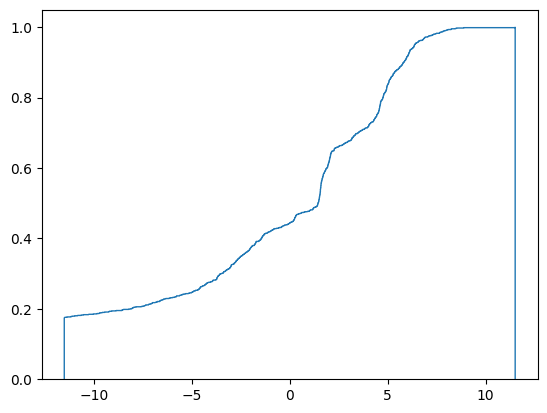

In [29]:
from models import SymbolicGaussianDiffusion, PointNetConfig

pconfig = PointNetConfig(
    embeddingSize=n_embd,
    numberofPoints=numPoints,
    numberofVars=numVars,
    numberofYs=numYs,
)
model = SymbolicGaussianDiffusion(
    tnet_config=pconfig,
    vocab_size=train_dataset.vocab_size,
    max_seq_len=32,
    padding_idx=test_dataset.paddingID,
    max_num_vars=9,
    n_layer=4,
    n_head=4,
    n_embd=n_embd,
    timesteps=timesteps,
    beta_start=0.0001,
    beta_end=0.02,
    set_transformer=False,
).to(device)

model_path = "/content/drive/MyDrive/Colab/STAT946_proj/models/2Var_tNet_best_model.pth"
model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
model.eval()

fName = "/content/drive/MyDrive/Colab/STAT946_proj/results/2Var_tNet.txt"
test_results = run_and_plot(model, fName, test_loader, textTest, train_dataset, device, pconfig, ddim_step=20, numTests=20)